# <span style='color:blue'> LAB 8: </span>
# <span style='color:blue'> GENERATIVE ADVERSARIAL NETWORKS </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [2]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

# MNIST Generation with Vanilla-GAN

## Prepare Data

In [3]:
from torchvision.datasets import MNIST 
from torch.utils.data import DataLoader
from torchvision import transforms

# Define a transformation to convert the data into Tensors
train_transforms = transforms.Compose([transforms.ToTensor()])

# Download the train and test MNIST data and transform it into Tensors
train_data = MNIST(root="./train.", train=True, download=True, transform=train_transforms)

## Define Model

In [4]:
class Generator(torch.nn.Module):
    
    def __init__(self, batchsize, input_noise_dim):
        
        super(Generator, self).__init__()
        
        self.batchsize = batchsize  # Batch size for input data
        self.input_noise_dim = input_noise_dim  # Dimension of the input data
        
        self.fc1 = torch.nn.Linear(input_noise_dim, 128)  # Fully connected layer 1
        self.LReLU = torch.nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = torch.nn.Linear(128, 1 * 28 * 28)  # Fully connected layer 2
        self.output = torch.nn.Tanh()  # Hyperbolic Tangent activation function

    def forward(self, x):
        
        layer1 = self.LReLU(self.fc1(x))  # Apply Leaky ReLU to the first fully connected layer
        layer2 = self.output(self.fc2(layer1))  # Apply Tanh to the second fully connected layer
        out = layer2.view(self.batchsize, 1, 28, 28)  # Reshape the output to match image dimensions
        
        return out

class Discriminator(torch.nn.Module):
    
    def __init__(self, batchsize):
        
        super(Discriminator, self).__init__()
        
        self.batchsize = batchsize  # Batch size for input data
        
        self.fc1 = torch.nn.Linear(1 * 28 * 28, 128)  # Fully connected layer 1
        self.LReLU = torch.nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = torch.nn.Linear(128, 1)  # Fully connected layer 2
        self.output = torch.nn.Sigmoid()  # Sigmoid activation function

    # Function for forward propagation
    def forward(self, x):
        
        flat = x.view(self.batchsize, -1)  # Flatten the input image
        layer1 = self.LReLU(self.fc1(flat))  # Apply Leaky ReLU to the first fully connected layer
        out = self.output(self.fc2(layer1))  # Apply Sigmoid to the second fully connected layer
        
        return out.view(-1, 1).squeeze(1)  # Flatten the output and remove unnecessary dimension

## Define Hyperparameters

In [5]:
# Fix random seed
torch.manual_seed(55)

# Define learning rate + epochs
learning_rate = 0.001         
epochs = 5

# Define batch size and num_features/timestep (this is simply the last dimension of train_output_seqs)
batchsize = 128
input_noise_dim = 100

# Create a Discriminator model
disc = Discriminator(batchsize)
gen = Generator(batchsize, input_noise_dim)

# Binary Cross Entropy (BCE) loss function
loss_func = torch.nn.BCELoss()
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, weight_decay=1e-05)
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, weight_decay=1e-05)

# Determine the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
disc.to(device)
gen.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (LReLU): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
  (output): Tanh()
)

## Identify Tracked Values

In [6]:
gen_train_loss_list = []
disc_train_loss_list = []

## Train Model

In [7]:
# Create DataLoader objects to efficiently load the training and test data in batches
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=False, drop_last=True)

In [8]:
# Set the device as CUDA or CPU based on availability
if torch.cuda.is_available():
    device = torch.device("cuda") 
else: 
    torch.device("cpu")

# Run training for each epoch
for epoch in range(epochs):
    
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    running_loss_D = 0
    running_loss_G = 0
    
    for inputs, labels in train_loader:
        
        inputs = inputs.to(device)
        
        # Convert labels into torch tensors with the proper size as per the batch size
        real_label = torch.full((batchsize,), 1, dtype=inputs.dtype, device=device)
        fake_label = torch.full((batchsize,), 0, dtype=inputs.dtype, device=device)

        # Train Discriminator --------------------------------------------------------------------------------------------------

        # Zero the gradients of the Discriminator optimizer
        optimizer_disc.zero_grad()
        
        # Compute output from the Discriminator
        output = disc(inputs)
        
        # Discriminator real loss
        D_real_loss = loss_func(output, real_label)
        D_real_loss.backward()
        
        # Generate random noise data as input to the Generator
        noise = torch.randn(batchsize, input_noise_dim, device=device)
        
        # Generate fake images using the Generator
        fake = gen(noise)
        
        # Pass fake images through the Discriminator with gradient detachment
        output = disc(fake.detach())
        
        # Discriminator fake loss
        D_fake_loss = loss_func(output, fake_label)
        D_fake_loss.backward()

        # Total loss for the Discriminator
        Disc_loss = D_real_loss + D_fake_loss
        running_loss_D += Disc_loss
        
        # Update Discriminator's parameters
        optimizer_disc.step()

        # Train Generator ------------------------------------------------------------------------------------------------------
        
        # Zero the gradients of the Generator optimizer
        optimizer_gen.zero_grad()
        
        # Pass fake images obtained from the Generator to the Discriminator
        output = disc(fake)
        
        # Calculate Generator loss by giving fake images as input but providing real labels
        Gen_loss = loss_func(output, real_label)
        running_loss_G += Gen_loss
        
        # Backpropagation for the Generator
        Gen_loss.backward()
        
        # Update Generator's parameters
        optimizer_gen.step()

        disc_train_loss_list.append(Disc_loss.item())
        gen_train_loss_list.append(Gen_loss.item())

    # Print the losses for the current epoch
    print("Discriminator Loss : {}".format(running_loss_D))
    print("Generator Loss : {}".format(running_loss_G))

Epoch 1/5
Discriminator Loss : 465.7514953613281
Generator Loss : 766.3235473632812
Epoch 2/5
Discriminator Loss : 575.15478515625
Generator Loss : 558.6425170898438
Epoch 3/5
Discriminator Loss : 455.2655334472656
Generator Loss : 671.4900512695312
Epoch 4/5
Discriminator Loss : 560.9201049804688
Generator Loss : 643.8521118164062
Epoch 5/5
Discriminator Loss : 544.8001098632812
Generator Loss : 574.6370239257812


## Visualize & Evaluate Model

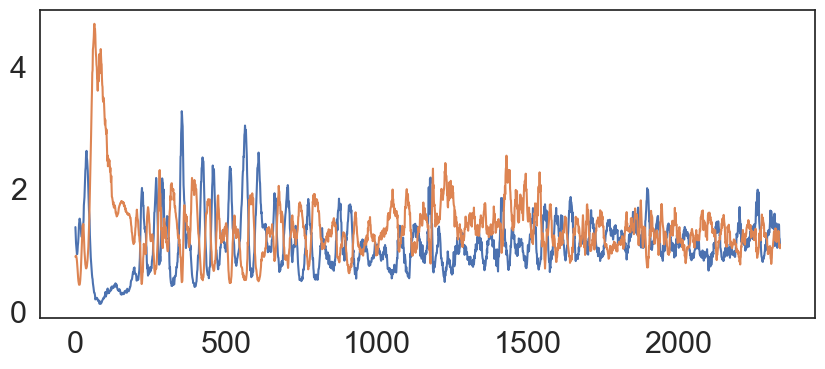

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))

plt.plot(disc_train_loss_list)
plt.plot(gen_train_loss_list)

In [11]:
# Function to plot an image
def show_image(img):
    # Convert the image from a tensor to a NumPy array
    npimg = img.numpy()
    # Transpose the NumPy array to the correct format for displaying
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


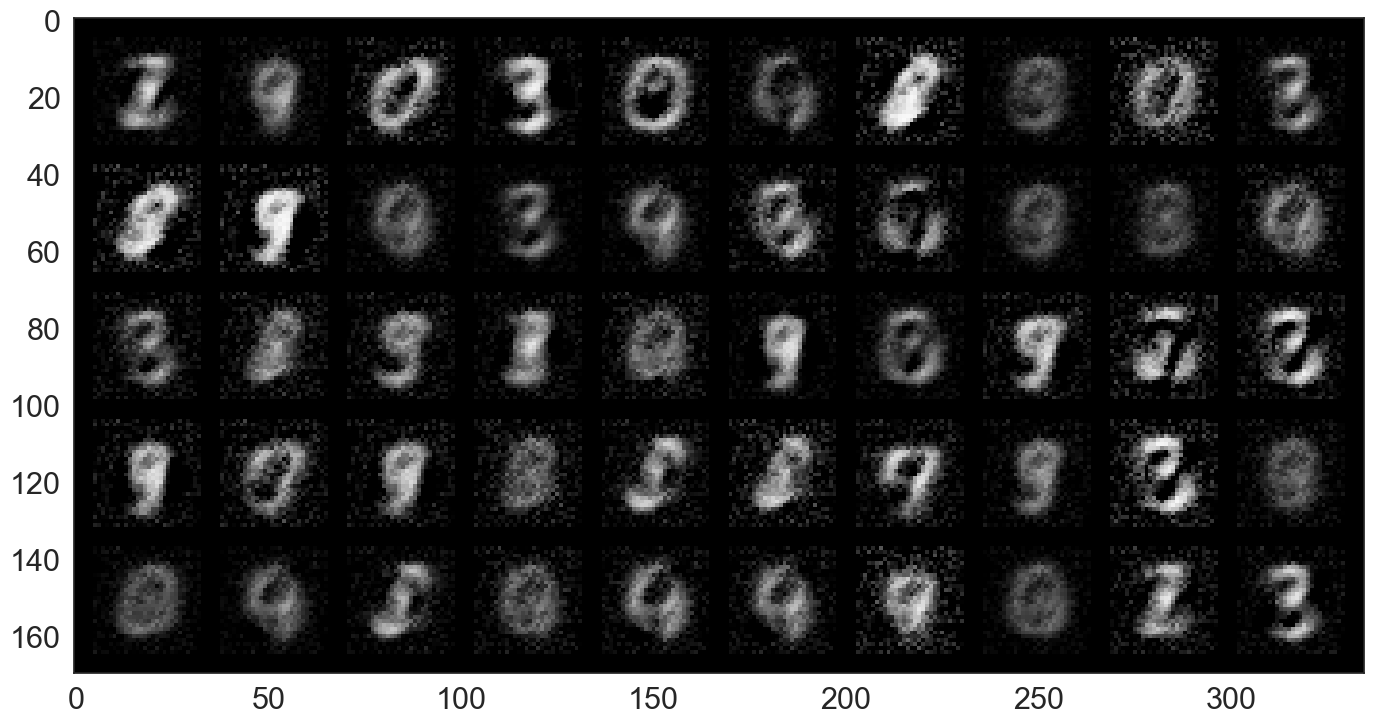

In [12]:
import torchvision

# Generate random noise for generating fake images
random_noise = torch.randn(128, input_noise_dim, device=device)

with torch.no_grad():
    
    # Generate fake images from the random noise using the Generator
    fake = gen(random_noise)
    fake = fake.cpu()  # Move the generated fake images to the CPU for displaying
    
    # Create a Matplotlib figure and axis for displaying the fake images
    fig, ax = plt.subplots(figsize=(20, 8.5))
    
    # Display the fake images in a grid (e.g., 10x5 grid)
    show_image(torchvision.utils.make_grid(fake[0:50], 10, 5))
    
    plt.show()